In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from icecream import ic
from tqdm import tqdm
import pandas as pd

In [2]:
data = pd.read_csv('../../Datasets/calib.txt', delimiter=' ', header=None)
data

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,P0:,707.091200,0.000000,601.88730,0.000000,0.000000,707.091200,183.110400,0.000000,0.000000,0.000000,1.000000,0.000000
1,P1:,707.091200,0.000000,601.88730,-379.814500,0.000000,707.091200,183.110400,0.000000,0.000000,0.000000,1.000000,0.000000
2,P2:,707.091200,0.000000,601.88730,46.887830,0.000000,707.091200,183.110400,0.117860,0.000000,0.000000,1.000000,0.006203
3,P3:,707.091200,0.000000,601.88730,-333.459700,0.000000,707.091200,183.110400,1.930130,0.000000,0.000000,1.000000,0.003318
4,Tr:,-0.001858,-0.999966,-0.00804,-0.004784,-0.006481,0.008052,-0.999947,-0.073374,0.999977,-0.001806,-0.006496,-0.333997


In [ ]:
p0 = np.array(data.iloc[0, 1:], dtype=np.float32).reshape((3, 4))
p1 = np.array(data.iloc[1, 1:], dtype=np.float32).reshape((3, 4))

# k: intrinsic, r: rotation, t: translation
# k1, r1, t1, _, _, _, _ = cv2.decomposeProjectionMatrix(p0)
# k2, r2, t2, _, _, _, _ = cv2.decomposeProjectionMatrix(p1)

In [4]:
file_path = '../../Datasets/08/image_0'
files = os.listdir(file_path)

(370, 1226)


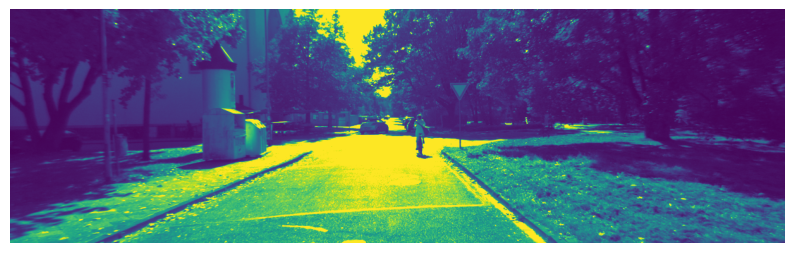

In [5]:
img = cv2.imread(os.path.join(file_path, files[0]), 0)
print(img.shape)
plt.figure(figsize=(10, 12))
plt.imshow(img)
plt.axis(False)
plt.show()

In [7]:
import datetime

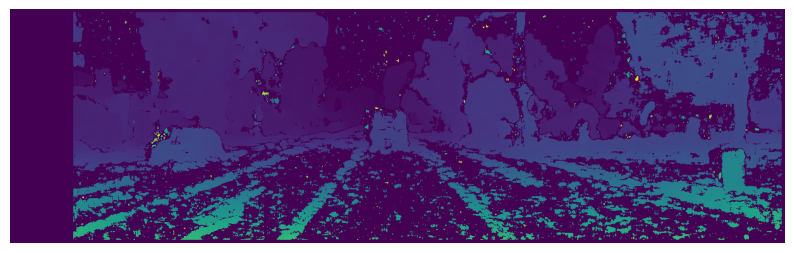

In [8]:
def compute_left_disparity_map(img_left, img_right, matcher='bm', rgb=False, verbose=False):
    # Feel free to read OpenCV documentation and tweak these values. These work well
    sad_window = 6
    num_disparities = sad_window*16
    block_size = 11
    matcher_name = matcher
    
    if matcher_name == 'bm':
        matcher = cv2.StereoBM_create(numDisparities=num_disparities,
                                      blockSize=block_size
                                     )
        
    elif matcher_name == 'sgbm':
        matcher = cv2.StereoSGBM_create(numDisparities=num_disparities,
                                        minDisparity=0,
                                        blockSize=block_size,
                                        P1 = 8 * 3 * sad_window ** 2,
                                        P2 = 32 * 3 * sad_window ** 2,
                                        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
                                       )
    if rgb:
        img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
        img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)
    start = datetime.datetime.now()
    disp_left = matcher.compute(img_left, img_right).astype(np.float32)/16
    end = datetime.datetime.now()
    if verbose:
        print(f'Time to compute disparity map using Stereo{matcher_name.upper()}:', end-start)
    
    return disp_left

left_file_path = '../../Datasets/04/image_0'
right_file_path = '../../Datasets/04/image_1'
left_images = os.listdir(left_file_path)
right_images = os.listdir(right_file_path)

# print(len(left_images), len(right_images))
# print(left_images)
left_images.sort()
right_images.sort()
img_left = cv2.imread(os.path.join(left_file_path, left_images[1]), 0)
img_right = cv2.imread(os.path.join(right_file_path, right_images[1]), 0)

disp = compute_left_disparity_map(img_left, img_right)

plt.figure(figsize=(10, 12))
plt.imshow(disp)
plt.axis(False)
plt.show()


(-0.5, 1225.5, 369.5, -0.5)

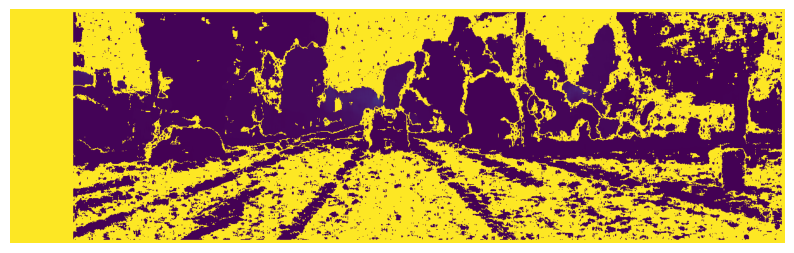

In [ ]:
def decompose_projection_matrix(p):
    '''
    Shortcut to use cv2.decomposeProjectionMatrix(), which only returns k, r, t, and divides
    t by the scale, then returns it as a vector with shape (3,) (non-homogeneous)
    
    Arguments:
    p -- projection matrix to be decomposed
    
    Returns:
    k, r, t -- intrinsic matrix, rotation matrix, and 3D translation vector
    
    '''
    k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(p)
    t = (t / t[3])[:3]
    
    return k, r, t

def calc_depth_map(disp_left, k_left, t_left, t_right, rectified=True):
    '''
    Calculate depth map using a disparity map, intrinsic camera matrix, and translation vectors
    from camera extrinsic matrices (to calculate baseline). Note that default behavior is for
    rectified projection matrix for right camera. If using a regular projection matrix, pass
    rectified=False to avoid issues.
    
    Arguments:
    disp_left -- disparity map of left camera
    k_left -- intrinsic matrix for left camera
    t_left -- translation vector for left camera
    t_right -- translation vector for right camera
    
    Optional Arguments:
    rectified -- (bool) set to False if t_right is not from rectified projection matrix
    
    Returns:
    depth_map -- calculated depth map for left camera
    
    '''
    # Get focal length of x axis for left camera
    f = k_left[0][0]
    
    # Calculate baseline of stereo pair
    if rectified:
        b = t_right[0] - t_left[0] 
    else:
        b = t_left[0] - t_right[0]
        
    # Avoid instability and division by zero
    disp_left[disp_left == 0.0] = 0.1
    disp_left[disp_left == -1.0] = 0.1
    
    # Make empty depth map then fill with depth
    depth_map = np.ones(disp_left.shape)
    depth_map = f * b / disp_left
    
    return depth_map

In [11]:
# this function takes the left and right images, the projection matrices for the left and right cameras,
def stereo_2_depth(img_left, img_right, P0, P1, matcher='bm', rgb=False, verbose=False, 
                   rectified=True):
    '''
    Takes stereo pair of images and returns a depth map for the left camera. If your projection
    matrices are not rectified, set rectified=False.
    
    Arguments:
    img_left -- image of left camera
    img_right -- image of right camera
    P0 -- Projection matrix for the left camera
    P1 -- Projection matrix for the right camera
    
    Optional Arguments:
    matcher -- (str) can be 'bm' for StereoBM or 'sgbm' for StereoSGBM
    rgb -- (bool) set to True if images passed are RGB. Default is False
    verbose -- (bool) set to True to report computation time and method
    rectified -- (bool) set to False if P1 not rectified to P0. Default is True
    
    Returns:
    depth -- depth map for left camera
    
    '''
    # Compute disparity map
    disp = compute_left_disparity_map(img_left, 
                                      img_right, 
                                      matcher=matcher, 
                                      rgb=rgb, 
                                      verbose=verbose)
    # Decompose projection matrices
    k_left, r_left, t_left = decompose_projection_matrix(P0)
    k_right, r_right, t_right = decompose_projection_matrix(P1)
    # Calculate depth map for left camera
    depth = calc_depth_map(disp, k_left, t_left, t_right)
    
    return depth

In [13]:
def extract_features(image, detector='sift', mask=None):
    """
    Find keypoints and descriptors for the image

    Arguments:
    image -- a grayscale image

    Returns:
    kp -- list of the extracted keypoints (features) in an image
    des -- list of the keypoint descriptors in an image
    """
    if detector == 'sift':
        det = cv2.SIFT_create()
    elif detector == 'orb':
        det = cv2.ORB_create()
    elif detector == 'surf':
        det = cv2.xfeatures2d.SURF_create()
        
    kp, des = det.detectAndCompute(image, mask)
    
    return kp, des

def match_features(des1, des2, matching='BF', detector='sift', sort=True, k=2):
    """
    Match features from two images

    Arguments:
    des1 -- list of the keypoint descriptors in the first image
    des2 -- list of the keypoint descriptors in the second image
    matching -- (str) can be 'BF' for Brute Force or 'FLANN'
    detector -- (str) can be 'sift or 'orb'. Default is 'sift'
    sort -- (bool) whether to sort matches by distance. Default is True
    k -- (int) number of neighbors to match to each feature.

    Returns:
    matches -- list of matched features from two images. Each match[i] is k or less matches for 
               the same query descriptor
    """
    if matching == 'BF':
        if detector == 'sift':
            matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=False)
        elif detector == 'orb':
            matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING2, crossCheck=False)
        matches = matcher.knnMatch(des1, des2, k=k)
    elif matching == 'FLANN':
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
        matches = matcher.knnMatch(des1, des2, k=k)
    
    if sort:
        matches = sorted(matches, key = lambda x:x[0].distance)

    return matches

In [14]:
def filter_matches_distance(matches, dist_threshold):
    """
    Filter matched features from two images by distance between the best matches

    Arguments:
    match -- list of matched features from two images
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
    filtered_match -- list of good matches, satisfying the distance threshold
    """
    filtered_match = []
    for m, n in matches:
        if m.distance <= dist_threshold*n.distance:
            filtered_match.append(m)

    return filtered_match

In [15]:
def visualize_matches(image1, kp1, image2, kp2, match):
    """
    Visualize corresponding matches in two images

    Arguments:
    image1 -- the first image in a matched image pair
    kp1 -- list of the keypoints in the first image
    image2 -- the second image in a matched image pair
    kp2 -- list of the keypoints in the second image
    match -- list of matched features from the pair of images

    Returns:
    image_matches -- an image showing the corresponding matches on both image1 and image2 or None if you don't use this function
    """
    image_matches = cv2.drawMatches(image1, kp1, image2, kp2, match, None, flags=2)
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(image_matches)

In [20]:
def estimate_motion(match, kp1, kp2, k, depth1=None, max_depth=3000):
    """
    Estimate camera motion from a pair of subsequent image frames

    Arguments:
    match -- list of matched features from the pair of images
    kp1 -- list of the keypoints in the first image
    kp2 -- list of the keypoints in the second image
    k -- camera intrinsic calibration matrix 
    
    Optional arguments:
    depth1 -- Depth map of the first frame. Set to None to use Essential Matrix decomposition
    max_depth -- Threshold of depth to ignore matched features. 3000 is default

    Returns:
    rmat -- estimated 3x3 rotation matrix
    tvec -- estimated 3x1 translation vector
    image1_points -- matched feature pixel coordinates in the first image. 
                     image1_points[i] = [u, v] -> pixel coordinates of i-th match
    image2_points -- matched feature pixel coordinates in the second image. 
                     image2_points[i] = [u, v] -> pixel coordinates of i-th match
               
    """
    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    
    image1_points = np.float32([kp1[m.queryIdx].pt for m in match])
    image2_points = np.float32([kp2[m.trainIdx].pt for m in match])

    if depth1 is not None:
        cx = k[0, 2]
        cy = k[1, 2]
        fx = k[0, 0]
        fy = k[1, 1]
        object_points = np.zeros((0, 3))
        delete = []

        # Extract depth information of query image at match points and build 3D positions
        for i, (u, v) in enumerate(image1_points):
            z = depth1[int(v), int(u)]
            # If the depth at the position of our matched feature is above 3000, then we
            # ignore this feature because we don't actually know the depth and it will throw
            # our calculations off. We add its index to a list of coordinates to delete from our
            # keypoint lists, and continue the loop. After the loop, we remove these indices
            if z > max_depth:
                delete.append(i)
                continue
                
            # Use arithmetic to extract x and y (faster than using inverse of k)
            x = z*(u-cx)/fx
            y = z*(v-cy)/fy
            object_points = np.vstack([object_points, np.array([x, y, z])])
            # Equivalent math with dot product w/ inverse of k matrix, but SLOWER (see Appendix A)
            #object_points = np.vstack([object_points, np.linalg.inv(k).dot(z*np.array([u, v, 1]))])

        image1_points = np.delete(image1_points, delete, 0)
        image2_points = np.delete(image2_points, delete, 0)
        
        # Use PnP algorithm with RANSAC for robustness to outliers
        _, rvec, tvec, inliers = cv2.solvePnPRansac(object_points, image2_points, k, None)
        print('Number of inliers: {}/{} matched features'.format(len(inliers), len(match)))
        
        # Above function returns axis angle rotation representation rvec, use Rodrigues formula
        # to convert this to our desired format of a 3x3 rotation matrix
        rmat = cv2.Rodrigues(rvec)[0]
    
    else:
        # With no depth provided, use essential matrix decomposition instead. This is not really
        # very useful, since you will get a 3D motion tracking but the scale will be ambiguous
        image1_points_hom = np.hstack([image1_points, np.ones(len(image1_points)).reshape(-1,1)])
        image2_points_hom = np.hstack([image2_points, np.ones(len(image2_points)).reshape(-1,1)])
        E = cv2.findEssentialMat(image1_points, image2_points, k)[0]
        _, rmat, tvec, mask = cv2.recoverPose(E, image1_points, image2_points, k)
    
    return rmat, tvec, image1_points, image2_points

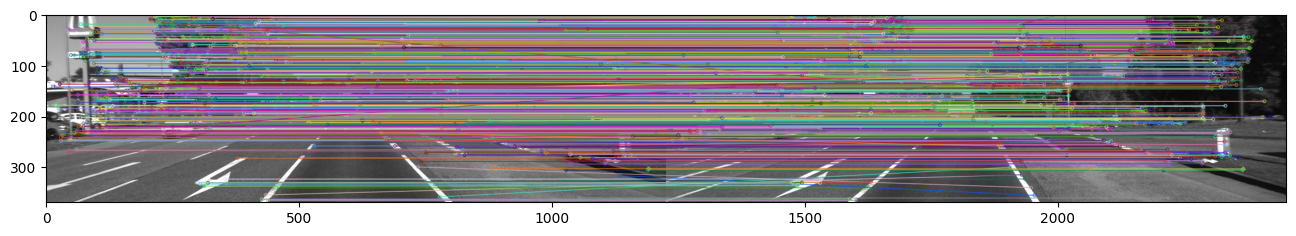

In [54]:
# def estimate_motion(match, kp1, kp2, k, depth1=None, max_depth=3000):


kp1, des1 = extract_features(img_left, detector='sift')
kp2, des2 = extract_features(img_right, detector='sift')
matches = match_features(des1, des2, matching='BF', detector='sift', sort=True, k=2)
filtered_matches = filter_matches_distance(matches, 0.75)
visualize_matches(img_left, kp1, img_right, kp2, filtered_matches)
# k1, r1, t1 = decompose_projection_matrix(p0)
# k2, r2, t2 = decompose_projection_matrix(p1)
# depth_map = stereo_2_depth(img_left, img_right, p0, p1, matcher='sgbm', rgb=False, verbose=False, rectified=True)

# rmat, tvec, image1_points, image2_points = estimate_motion(filtered_matches, kp1, kp2, k1, depth_map)

# v

In [ ]:
# class dataset_handler():
#     def __init__(self, dir = ''):
#         self.dir = dir
#         # these 2 have the left & right images files names  
#         self.left_file_path = os.path.join(dir, 'image_0')
#         self.right_file_path = os.path.join(dir, 'image_1')
#         self.P0 = np.array(data.iloc[0, 1:], dtype=np.float32).reshape((3, 4)) #this has left cam projection matrix
#         self.P1 = np.array(data.iloc[1, 1:], dtype=np.float32).reshape((3, 4)) #this has right cam projection matrix
#         self.num_frames = len(os.listdir(self.left_file_path)) #this has number of frames
#         self.gt = None # ground truth trajectory
#         self.imheight, self.imwidth = 370, 1226 #~ image size (change it later)
#         self.lidar = None #~remove it later
#         self.low_memory = False #~ remove it later
        
        
#     def load_image(self, filepath):
#         image_paths = [os.path.join(filepath, file) for file in sorted(os.listdir(filepath))]
#         return [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in tqdm(image_paths, desc="Loading images")]

In [40]:
class Dataset_Handler():
    def __init__(self, sequence, lidar=False, progress_bar=True, low_memory=True):
        import pandas as pd
        import os
        import cv2
        
        # This will tell our odometry function if handler contains lidar info
        self.lidar = lidar
        # This will tell odometry functin how to access data from this object
        self.low_memory = low_memory
        
        # Set file paths and get ground truth poses
        # self.seq_dir = '../dataset/sequences/{}/'.format(sequence)
        self.seq_dir = sequence
        # self.poses_dir = '../dataset/poses/{}.txt'.format(sequence)
        # poses = pd.read_csv(self.poses_dir, delimiter=' ', header=None)
        
        # Get sorted names of files to iterate through
        self.left_image_files = sorted(os.listdir(self.seq_dir + 'image_0'), key=lambda x: int(x.split(".")[0]))
        self.right_image_files = sorted(os.listdir(self.seq_dir + 'image_1'), key=lambda x: int(x.split(".")[0]))
        # self.velodyne_files = os.listdir(self.seq_dir + 'velodyne')
        self.num_frames = len(self.left_image_files)
        self.lidar_path = self.seq_dir + 'velodyne/'
        
        # Get calibration details for scene
        # P0 and P1 are Grayscale cams, P2 and P3 are RGB cams
        calib = pd.read_csv(self.seq_dir + 'calib.txt', delimiter=' ', header=None, index_col=0)
        self.P0 = np.array(calib.loc['P0:']).reshape((3,4))
        self.P1 = np.array(calib.loc['P1:']).reshape((3,4))
        self.P2 = np.array(calib.loc['P2:']).reshape((3,4))
        self.P3 = np.array(calib.loc['P3:']).reshape((3,4))
        # This is the transformation matrix for LIDAR
        # self.Tr = np.array(calib.loc['Tr:']).reshape((3,4))
        
        # Get times and ground truth poses
        self.times = np.array(pd.read_csv(self.seq_dir + 'times.txt', 
                                          delimiter=' ', 
                                          header=None))
        # self.gt = np.zeros((len(poses), 3, 4))
        # for i in range(len(poses)):
            # self.gt[i] = np.array(poses.iloc[i]).reshape((3, 4))
        
        # Get images and lidar loaded
        if self.low_memory:
            # Will use generators to provide data sequentially to save RAM
            # Use class method to set up generators
            self.reset_frames()
            # Store original frame to memory for testing functions
            self.first_image_left = cv2.imread(self.seq_dir + 'image_0/' 
                                               + self.left_image_files[0], 0)
            self.first_image_right = cv2.imread(self.seq_dir + 'image_1/' 
                                               + self.right_image_files[0], 0)
            self.second_image_left = cv2.imread(self.seq_dir + 'image_0/' 
                                               + self.left_image_files[1], 0)
            if self.lidar:
                self.first_pointcloud = np.fromfile(self.lidar_path + self.velodyne_files[0],
                                                    dtype=np.float32, 
                                                    count=-1).reshape((-1, 4))
            self.imheight = self.first_image_left.shape[0]
            self.imwidth = self.first_image_left.shape[1]
            
        else:
            # If RAM is not a concern (>32GB), pass low_memory=False
            if progress_bar:
                import progressbar
                bar = progressbar.ProgressBar(max_value=self.num_frames)
            self.images_left = []
            self.images_right = []
            self.pointclouds = []
            for i, name_left in enumerate(self.left_image_files):
                name_right = self.right_image_files[i]
                self.images_left.append(cv2.imread(self.seq_dir + 'image_0/' + name_left))
                self.images_right.append(cv2.imread(self.seq_dir + 'image_1/' + name_right))
                if self.lidar:
                    pointcloud = np.fromfile(self.lidar_path + self.velodyne_files[i], 
                                             dtype=np.float32, 
                                             count=-1).reshape([-1,4])
                    self.pointclouds.append(pointcloud)
                if progress_bar:
                    bar.update(i+1)
                
            self.imheight = self.images_left[0].shape[0]
            self.imwidth = self.images_left[0].shape[1]
            # Keep consistent instance variable names as when using low_memory
            self.first_image_left = self.images_left[0]
            self.first_image_right = self.images_right[0]
            self.second_image_left = self.images_left[1]
            if self.lidar:
                self.first_pointcloud = self.pointclouds[0]
            
    def reset_frames(self):
        # Resets all generators to the first frame of the sequence
        self.images_left = (cv2.imread(self.seq_dir + 'image_0/' + name_left, 0)
                            for name_left in self.left_image_files)
        self.images_right = (cv2.imread(self.seq_dir + 'image_1/' + name_right, 0)
                            for name_right in self.right_image_files)
        if self.lidar:
            self.pointclouds = (np.fromfile(self.lidar_path + velodyne_file, 
                                            dtype=np.float32, 
                                            count=-1).reshape((-1, 4))
                                for velodyne_file in self.velodyne_files)
        pass

In [ ]:
def visual_odometry(handler, detector='sift', matching='BF', filter_match_distance=None, 
                    stereo_matcher='bm', mask=None, depth_type='stereo', subset=None,
                    plot=False, ply = True ):
    '''
    Function to perform visual odometry on a sequence from the KITTI visual odometry dataset.
    Takes as input a Data_Handler object and optional parameters.
    
    Arguments:
    handler -- Data_Handler object instance
    
    Optional Arguments:
    detector -- (str) can be 'sift' or 'orb'. Default is 'sift'.
    matching -- (str) can be 'BF' for Brute Force or 'FLANN'. Default is 'BF'.
    filter_match_distance -- (float) value for ratio test on matched features. Default is None.
    stereo_matcher -- (str) can be 'bm' (faster) or 'sgbm' (more accurate). Default is 'bm'.
    mask -- (array) mask to reduce feature search area to where depth information available.
    depth_type -- (str) can be 'stereo' or set to None to use Essential matrix decomposition.
                        Note that scale will be incorrect with no depth used.
    subset -- (int) number of frames to compute. Defaults to None to compute all frames.
    plot -- (bool) whether to plot the estimated vs ground truth trajectory. Only works if
                   matplotlib is set to tk mode. Default is False.
    
    Returns:
    trajectory -- Array of shape Nx3x4 of estimated poses of vehicle for each computed frame.
    
    '''

  # Determine if handler has lidar data
    lidar = handler.lidar
    
    # Report methods being used to user
    print('Generating disparities with Stereo{}'.format(str.upper(stereo_matcher)))
    print('Detecting features with {} and matching with {}'.format(str.upper(detector), 
                                                                   matching))
    if filter_match_distance is not None:
        print('Filtering feature matches at threshold of {}*distance'.format(filter_match_distance))
    if lidar:
        print('Improving stereo depth estimation with lidar data')
    if subset is not None:
        #subset = subset + 1
        num_frames = subset
    else:
        # Set num_frames to one less than the number of frames so we have sequential images
        # in the last frame run.
        num_frames = handler.num_frames
        
    # if plot:
    #     fig = plt.figure(figsize=(14, 14))
    #     ax = fig.add_subplot(projection='3d')
    #     ax.view_init(elev=-20, azim=270)
    #     xs = handler.gt[:, 0, 3]
    #     ys = handler.gt[:, 1, 3]
    #     zs = handler.gt[:, 2, 3]
    #     ax.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs)))
    #     ax.plot(xs, ys, zs, c='k')
        
    # Establish homogeneous transformation matrix. First pose is identity    
    T_tot = np.eye(4)
    trajectory = np.zeros((num_frames, 3, 4))
    trajectory[0] = T_tot[:3, :]
    imheight = handler.imheight
    imwidth = handler.imwidth
    
    # Decompose left camera projection matrix to get intrinsic k matrix
    k_left, r_left, t_left = decompose_projection_matrix(handler.P0)
    
    if handler.low_memory:
        handler.reset_frames()
        image_plus1 = next(handler.images_left)
    
    # Iterate through all frames of the sequence
    for i in range(num_frames - 1):
        # Stop if we've reached the second to last frame, since we need two sequential frames
        #if i == num_frames - 1:
        #    break
        # Start timer for frame
        start = datetime.datetime.now()
        # Get our stereo images for depth estimation
        if handler.low_memory:
            image_left = image_plus1
            image_right = next(handler.images_right)
            # Get next frame in the left camera for visual odometry
            image_plus1 = next(handler.images_left)
        else:
            image_left = handler.images_left[i]
            image_right = handler.images_right[i]
            # Get next frame in the left camera for visual odometry
            image_plus1 = handler.images_left[i+1]
        
        # Estimate depth if using stereo depth estimation (recommended)
        if depth_type == 'stereo':
            depth = stereo_2_depth(image_left, 
                                   image_right, 
                                   P0=handler.P0, 
                                   P1=handler.P1,
                                   matcher=stereo_matcher)
        # Otherwise use Essential Matrix decomposition (ambiguous scale)
        else:
            depth = None
            
        # # Supercede stereo depth estimations where lidar points are available
        # if lidar:
        #     if handler.low_memory:
        #         pointcloud = next(handler.pointclouds)
        #     else:
        #         pointcloud = handler.pointclouds[i]
        #     lidar_depth = pointcloud2image(pointcloud, 
        #                                    imheight=imheight, 
        #                                    imwidth=imwidth, 
        #                                    Tr=handler.Tr, 
        #                                    P0=handler.P0)
        #     indices = np.where(lidar_depth < 3000)
        #     depth[indices] = lidar_depth[indices]
            
        # Get keypoints and descriptors for left camera image of two sequential frames
        kp0, des0 = extract_features(image_left, detector, mask)
        kp1, des1 = extract_features(image_plus1, detector, mask)
        
        # Get matches between features detected in the two images
        matches_unfilt = match_features(des0, 
                                        des1, 
                                        matching=matching, 
                                        detector=detector, 
                                        sort=True)
        
        # Filter matches if a distance threshold is provided by user
        if filter_match_distance is not None:
            matches = filter_matches_distance(matches_unfilt, filter_match_distance)
        else:
            matches = matches_unfilt
            
        # Estimate motion between sequential images of the left camera
        rmat, tvec, img1_points, img2_points = estimate_motion(matches, kp0, kp1, k_left, depth)
        
        # The following code is commented out because it is only necessary if you intend to
        # use very low distance ratios for match filtering. Feel free to uncomment and try
        # out using very low distance ratios, but if you do, comment out the above line.
        # Try to get motion with filter distance, if not increase threshold until success
        #try:
        #    rmat, tvec, img1_points, img2_points = estimate_motion(matches, 
        #                                                           kp0, 
        #                                                           kp1, 
        #                                                           k_left, 
        #                                                           depth)
        #except:
        #    filt_inc = 0.1
        #    while True:
        #        print('Not enough features after filter with threshold {},'.format(filter_match_distance),
        #              'raising threshold to {} until next frame.'.format(filter_match_distance + filt_inc)) 
        #        try:
        #            matches = filter_matches_distance(matches_unfilt, filter_match_distance+filt_inc)
        #            rmat, tvec, img1_points, img2_points = estimate_motion(matches, 
        #                                                                   kp0, 
        #                                                                   kp1, 
        #                                                                   k_left, 
        #                                                                   depth)
        #            break
        #        except:
        #            filt_inc += 0.1
        #            continue
                  
        # Create blank homogeneous transformation matrix
        Tmat = np.eye(4)
        # Place resulting rotation matrix  and translation vector in their proper locations
        # in homogeneous T matrix
        Tmat[:3, :3] = rmat
        Tmat[:3, 3] = tvec.T
        
        # The SolvePnPRansac() function computes a pose that relates points in the global
        # coordinate frame to the camera's pose. We used the camera's pose in the first image
        # as the global coordinate frame, reconstruct 3D positions of the features in the
        # image using stereo depth estimation, then find a pose which relates the camera in
        # the next frame to those 3D points. When tracking the vehicle pose over time, what we
        # actually want is to relate the points in the camera's coordinate frame to the global
        # frame, so we want the opposite (inverse) of the transformation matrix provided to us
        # by the SolvePnPRansac function. Recall from the earlier discussion that we can find
        # the inverse of a transformation matrix by making it homogeneous by adding a row of
        # (0, 0, 0, 1) to it, then taking its inverse. Further, we are tracking the vehicle
        # motion from the very first camera pose, so we need the cumulative product of the
        # inverses of each estimated camera pose given to us by SolvePnPRansac. Thus, below
        # we iteratively multiply the T_tot homogeneous transformation matrix that we 
        # instantiated before the for loop by the inverse of each successive pose we estimate,
        # and save its current values into our estimated poses at an index corresponding to our
        # current frame. This way, the transformation matrix at each index will be one that
        # relates 3D homogeneous coordinates in the camera's frame to the global coordinate
        # frame, which is the coordinate frame of the camera's first position. The translation
        # vector component of this transformation matrix will describe where the camera's curent
        # origin is in this global referece frame.
        T_tot = T_tot.dot(np.linalg.inv(Tmat))
            
        # Place pose estimate in i+1 to correspond to the second image, which we estimated for
        trajectory[i+1, :, :] = T_tot[:3, :]
        # End the timer for the frame and report frame rate to user
        end = datetime.datetime.now()
        print('Time to compute frame {}:'.format(i+1), end-start)
        
        if plot:
            xs = trajectory[:i+2, 0, 3]
            ys = trajectory[:i+2, 1, 3]
            zs = trajectory[:i+2, 2, 3]
            plt.plot(xs, ys, zs, c='chartreuse')
            plt.pause(1e-32)
            
    if plot:        
        plt.close()
        
    return trajectory

In [49]:
import numpy as np
import datetime
import os
import open3d as o3d
# (Make sure other required imports such as matplotlib, etc., are present)

def visual_odometry(handler, detector='sift', matching='BF', filter_match_distance=None, 
                    stereo_matcher='bm', mask=None, depth_type='stereo', subset=None,
                    plot=False, ply=True):
    '''
    Function to perform visual odometry on a sequence from the KITTI visual odometry dataset.
    ...
    Optional Arguments:
      ply -- (bool) if True, after processing the trajectory, save all reconstructed 3D points
             into a single point cloud file (.ply) and visualize using Open3D.
    Returns:
      trajectory -- Array of shape Nx3x4 of estimated poses of the vehicle for each computed frame.
    '''

    # Determine if handler has lidar data
    lidar = handler.lidar
    
    # Report methods being used to user
    print('Generating disparities with Stereo{}'.format(str.upper(stereo_matcher)))
    print('Detecting features with {} and matching with {}'.format(str.upper(detector), matching))
    if filter_match_distance is not None:
        print('Filtering feature matches at threshold of {}*distance'.format(filter_match_distance))
    if lidar:
        print('Improving stereo depth estimation with lidar data')
    if subset is not None:
        num_frames = subset
    else:
        num_frames = handler.num_frames
        
    # Establish homogeneous transformation matrix. First pose is identity    
    T_tot = np.eye(4)
    trajectory = np.zeros((num_frames, 3, 4))
    trajectory[0] = T_tot[:3, :]
    imheight = handler.imheight
    imwidth = handler.imwidth
    
    # Decompose left camera projection matrix to get intrinsic k matrix
    k_left, r_left, t_left = decompose_projection_matrix(handler.P0)
    
    # If saving all points, initialize a list to accumulate global 3D points.
    all_points_list = [] if ply else None
    
    if handler.low_memory:
        handler.reset_frames()
        image_plus1 = next(handler.images_left)
    
    # Iterate through frames
    for i in range(num_frames - 1):
        start = datetime.datetime.now()
        # Retrieve images depending on memory mode
        if handler.low_memory:
            image_left = image_plus1
            image_right = next(handler.images_right)
            image_plus1 = next(handler.images_left)
        else:
            image_left = handler.images_left[i]
            image_right = handler.images_right[i]
            image_plus1 = handler.images_left[i+1]
        
        # Compute depth using stereo depth estimation (or set to None if not used)
        if depth_type == 'stereo':
            depth = stereo_2_depth(image_left, 
                                   image_right, 
                                   P0=handler.P0, 
                                   P1=handler.P1,
                                   matcher=stereo_matcher)
        else:
            depth = None
            
        # Extract keypoints and descriptors for sequential left images
        kp0, des0 = extract_features(image_left, detector, mask)
        kp1, des1 = extract_features(image_plus1, detector, mask)
        
        # Compute matches between frames
        matches_unfilt = match_features(des0, des1, matching=matching, detector=detector, sort=True)
        if filter_match_distance is not None:
            matches = filter_matches_distance(matches_unfilt, filter_match_distance)
        else:
            matches = matches_unfilt
            
        # Estimate motion between images; also obtain keypoint coordinates used
        rmat, tvec, img1_points, img2_points = estimate_motion(matches, kp0, kp1, k_left, depth)
        
        # Build transformation matrix for current frame from rotation and translation estimates
        Tmat = np.eye(4)
        Tmat[:3, :3] = rmat
        Tmat[:3, 3] = tvec.T
        
        # Update the total transformation (from the first frame to current)
        T_tot = T_tot.dot(np.linalg.inv(Tmat))
        trajectory[i+1, :, :] = T_tot[:3, :]
        
        # If ply saving is enabled and stereo depth is used,
        # backproject the 2D points from the first image to 3D and transform them into global coordinates.
        if ply and depth is not None:
            pts_3d = []
            for pt in img1_points:
                u, v = int(pt[0]), int(pt[1])
                # Verify valid indices in the depth map
                if 0 <= v < depth.shape[0] and 0 <= u < depth.shape[1]:
                    z = depth[v, u]
                    if z == 0:
                        continue  # Skip invalid depth
                    fx, fy = k_left[0, 0], k_left[1, 1]
                    cx, cy = k_left[0, 2], k_left[1, 2]
                    x = (u - cx) * z / fx
                    y = (v - cy) * z / fy
                    pts_3d.append([x, y, z, 1])
            
            # Transform the computed 3D points from camera to global coordinates using T_tot.
            if pts_3d:
                pts_3d = np.array(pts_3d).T  # Shape becomes 4 x N
                global_pts = T_tot.dot(pts_3d).T  # Each row is [X, Y, Z, _]
                global_pts = global_pts[:, :3]  # Drop homogeneous coordinate
                all_points_list.extend(global_pts.tolist())
        
        end = datetime.datetime.now()
        print('Time to compute frame {}:'.format(i+1), end - start)
        
        if plot:
            xs = trajectory[:i+2, 0, 3]
            ys = trajectory[:i+2, 1, 3]
            zs = trajectory[:i+2, 2, 3]
            # Plotting code (for example using matplotlib)
            plt.plot(xs, ys, zs, c='chartreuse')
            plt.pause(1e-32)
            
    if plot:        
        plt.close()
    
    # After processing all frames, if ply is enabled, create an aggregated point cloud.
    # if ply and all_points_list:
    #     pcd = o3d.geometry.PointCloud()
    #     all_points_np = np.array(all_points_list)
    #     pcd.points = o3d.utility.Vector3dVector(all_points_np)
        
    #     # Optionally, you can set a default color.
    #     colors = np.tile([0.5, 0.5, 0.5], (all_points_np.shape[0], 1))
    #     pcd.colors = o3d.utility.Vector3dVector(colors)
        
    #     os.makedirs("pointclouds", exist_ok=True)
    #     ply_filename = os.path.join("pointclouds", "all_points.ply")
    #     o3d.io.write_point_cloud(ply_filename, pcd)
    #     print(f"Aggregated point cloud saved to {ply_filename}")
        
    #     # Visualize the aggregated point cloud.
    #     o3d.visualization.draw_geometries([pcd])
        
    return trajectory, all_points_list


In [50]:
# def visual_odometry(handler, detector='sift', matching='BF', filter_match_distance=None, 
                    # stereo_matcher='bm', mask=None, depth_type='stereo', subset=None,
                    # plot=False):
                    
trajectory, points = visual_odometry(handler=Dataset_Handler(sequence='../../Datasets/04/'),
                            detector='sift', 
                            matching='BF', 
                            filter_match_distance=0.75, 
                            stereo_matcher='sgbm', 
                            mask=None, 
                            depth_type='stereo', 
                            subset=None,
                            plot=False)

Generating disparities with StereoSGBM
Detecting features with SIFT and matching with BF
Filtering feature matches at threshold of 0.75*distance
Number of inliers: 1088/1192 matched features
Time to compute frame 1: 0:00:00.192268
Number of inliers: 1065/1172 matched features
Time to compute frame 2: 0:00:00.185989
Number of inliers: 1088/1207 matched features
Time to compute frame 3: 0:00:00.206701
Number of inliers: 1079/1150 matched features
Time to compute frame 4: 0:00:00.214294
Number of inliers: 1116/1179 matched features
Time to compute frame 5: 0:00:00.208669
Number of inliers: 1087/1182 matched features
Time to compute frame 6: 0:00:00.175140
Number of inliers: 1150/1221 matched features
Time to compute frame 7: 0:00:00.212271
Number of inliers: 1192/1253 matched features
Time to compute frame 8: 0:00:00.197268
Number of inliers: 1199/1291 matched features
Time to compute frame 9: 0:00:00.201212
Number of inliers: 1171/1246 matched features
Time to compute frame 10: 0:00:00.1

In [51]:
np.array(points).shape

(259533, 3)

In [ ]:
#visualise the numpy using open3d
import open3d as o3d


points = np.array(points)

open3d_points = o3d.geometry.PointCloud()
open3d_points.points = o3d.utility.Vector3dVector(points)
open3d_points.paint_uniform_color([0.5, 0.5, 0.5])  # Set color to gray

# Visualize the point cloud
o3d.visualization.draw_geometries([open3d_points])

[Open3D WARNING] GLFW Error: EGL: Failed to initialize EGL: EGL is not or could not be initialized
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)



In [53]:
np.save('points.npy', points)